### Implement Value at Risk & Conditional Value at Risk using : 
#### 1. Historical Method
#### 2. Parametric Method (Variance-Covariance)
#### 3. Monte Carlo Method

In [5]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt

In [6]:
# Import data
def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock+'.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns['portfolio'] = returns.dot(weights)

In [7]:
returns

Symbols,CBA.AX,BHP.AX,TLS.AX,NAB.AX,WBC.AX,STO.AX,portfolio
Date,,,,,,,
2019-12-30,-0.014797,-0.012684,-0.027473,-0.010446,-0.006967,-0.020359,-0.013500
2020-01-01,-0.000250,0.000771,0.011299,-0.002436,-0.001651,0.004890,0.001076
2020-01-02,0.005383,0.005135,0.002793,0.006105,0.007028,0.023114,0.010962
2020-01-05,-0.006724,0.006386,0.008357,-0.006877,-0.000821,0.021403,0.006706
2020-01-06,0.017927,0.003807,0.024862,0.014257,0.011504,0.023283,0.013746
...,...,...,...,...,...,...,...
2022-02-27,-0.004474,0.044081,0.005076,0.001038,-0.000876,0.015385,0.015701
2022-02-28,0.014552,-0.002357,0.000000,0.014858,0.006576,0.000000,0.003492
2022-03-01,-0.001266,0.038024,-0.005051,-0.012598,-0.016550,0.061983,0.022746


#### 1. Historical Method

##### Value at Risk function

In [8]:
def historicalVaR(returns, alpha = 5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    # aggregate to evaluate DataFrame as a Series
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha = alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

In [9]:
historicalVaR(returns, alpha = 5)

Symbols
CBA.AX      -0.024876
BHP.AX      -0.029994
TLS.AX      -0.020605
NAB.AX      -0.025625
WBC.AX      -0.028362
STO.AX      -0.037287
portfolio   -0.025804
dtype: float64

In [10]:
historicalVaR(returns['portfolio'], alpha = 5)

-0.025804182731812182

##### Conditional Value at Risk function

In [13]:
def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

In [14]:
historicalCVaR(returns, alpha = 5)

Symbols
CBA.AX      -0.046812
BHP.AX      -0.048973
TLS.AX      -0.034704
NAB.AX      -0.051182
WBC.AX      -0.053822
STO.AX      -0.069371
portfolio   -0.047471
dtype: float64

In [15]:
historicalCVaR(returns['portfolio'], alpha = 5)

-0.04747114696122058

In [19]:
# 1 day
Time = 1

VaR = -historicalVaR(returns['portfolio'], alpha = 5)*np.sqrt(Time)
CVaR = -historicalCVaR(returns['portfolio'], alpha = 5)*np.sqrt(Time)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)

InitialInvestment = 100000
print('Expected Portfolio Return :   ', round(InitialInvestment*pRet, 2))
print('Value at Risk 95th CI :       ', round(InitialInvestment*VaR, 2))      
print('Conditional VaR 95th CI :     ', round(InitialInvestment*CVaR, 2))

Expected Portfolio Return :    39.48
Value at Risk 95th CI :        2580.42
Conditional VaR 95th CI :      4747.11


Over 1 day time horizon, we expected to make 40 dollars, but 95th CI, we are not gonna lose no more than 2580,42 dollars, in a day historically, in a low 5th percentile, the expected loss (expected shortfall), we expected to loss 4747,11 dollars

#### 2. Parametric Method (Variance-Covariance)

$t VaR_{\nu,\alpha,h} = \sqrt{\nu^{-1}(\nu - 2)}t_{\nu}^{-1}(1 - \alpha)\sigma_{h} - \mu_h$  
  
$t CVaR_{\nu,\alpha,h} = -\alpha^{-1}(1 - \nu)^{-1}(\nu - 2 + x^2_{\alpha,\nu})f_{\nu}(x_{\alpha,\nu})\sigma_{h} - \mu_h$  

###### VaR parametric

In [20]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    """
    Calculate the portfolio VaR given a distribution, with known parameters
        dof = degree of freedom
    """
    
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        # to look for the formula of t VaR
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

###### CVaR parametric

In [21]:
def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        # to look for the formula of t CVaR
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [24]:
normVaR = var_parametric(pRet, pStd,)
normCVaR = cvar_parametric(pRet, pStd)

In [25]:
tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

In [26]:
print('normal VaR 95th CI :    ', round(InitialInvestment*normVaR, 2))
print('normal CVaR 95th CI :    ', round(InitialInvestment*normCVaR, 2))

print('t-dist VaR 95th CI :    ', round(InitialInvestment*tVaR, 2))
print('t-dist CVaR 95th CI :    ', round(InitialInvestment*tCVaR, 2))

normal VaR 95th CI :     3212.01
normal CVaR 95th CI :     4038.01
t-dist VaR 95th CI :     3096.85
t-dist CVaR 95th CI :     4222.75


#### 3. Monte Carlo method

In [31]:
"""
Implement the Monte Carlo Method to simulate a stock portfolio
"""

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)

returns, meanReturns, covMatrix = getData(stocks, startDate, endDate)

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio


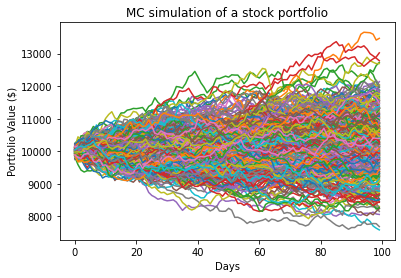

In [32]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

###### VaR, CVaR Monte Carlo functions

In [34]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [36]:
portResults = pd.Series(portfolio_sims[-1, :])
VaR = initialPortfolio - mcVaR(portResults, alpha = 5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha = 5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $1333.44
CVaR $1664.82
